In [1]:
# Setup cell.
import numpy as np
import matplotlib.pyplot as plt
from cnn import *
from data_utils import get_CIFAR10_data
from layers import *
from fast_layers import *
from solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


In [3]:
!python setup.py build_ext --inplace

running build_ext


In [4]:
pip install Cython

^C
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Rel errors should be around e-9 or less.
from fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 8.833341s
Fast: 0.034457s
Speedup: 256.355067x
Difference:  4.926407851494105e-11

Testing conv_backward_fast:
Naive: 21.277648s
Fast: 0.028924s
Speedup: 735.652307x
dx difference:  1.949764775345631e-11
dw difference:  4.957046344783224e-13
db difference:  3.481354613192702e-14


In [19]:
# Relative errors should be close to 0.0.
from fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.311715s
fast: 0.006980s
speedup: 44.660188x
difference:  0.0

Testing pool_backward_fast:
Naive: 2.099463s
fast: 0.024934s
speedup: 84.200620x
dx difference:  0.0


In [21]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302586630973189
Initial loss (with regularization):  2.508695802231438


In [22]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(
    model,
    small_data,
    num_epochs=15,
    batch_size=50,
    update_rule='adam',
    optim_config={'learning_rate': 1e-3,},
    verbose=True,
    print_every=1
)
solver.train()

(Iteration 1 / 30) loss: 2.670487
(Epoch 0 / 15) train acc: 0.200000; val_acc: 0.127000
(Iteration 2 / 30) loss: 2.463370
(Epoch 1 / 15) train acc: 0.220000; val_acc: 0.122000
(Iteration 3 / 30) loss: 3.089000
(Iteration 4 / 30) loss: 2.659823
(Epoch 2 / 15) train acc: 0.160000; val_acc: 0.107000
(Iteration 5 / 30) loss: 2.613649
(Iteration 6 / 30) loss: 2.438302
(Epoch 3 / 15) train acc: 0.210000; val_acc: 0.089000
(Iteration 7 / 30) loss: 2.109035
(Iteration 8 / 30) loss: 2.100708
(Epoch 4 / 15) train acc: 0.230000; val_acc: 0.108000
(Iteration 9 / 30) loss: 2.197319
(Iteration 10 / 30) loss: 1.940376
(Epoch 5 / 15) train acc: 0.250000; val_acc: 0.120000
(Iteration 11 / 30) loss: 1.867510
(Iteration 12 / 30) loss: 1.764319
(Epoch 6 / 15) train acc: 0.310000; val_acc: 0.134000
(Iteration 13 / 30) loss: 2.151846
(Iteration 14 / 30) loss: 2.093021
(Epoch 7 / 15) train acc: 0.320000; val_acc: 0.160000
(Iteration 15 / 30) loss: 1.735965
(Iteration 16 / 30) loss: 1.721776
(Epoch 8 / 15) tr

In [23]:
# Print final training accuracy.
print(
    "Small data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

Small data training accuracy: 0.52


In [24]:
# Print final validation accuracy.
print(
    "Small data validation accuracy:",
    solver.check_accuracy(small_data['X_val'], small_data['y_val'])
)

Small data validation accuracy: 0.185


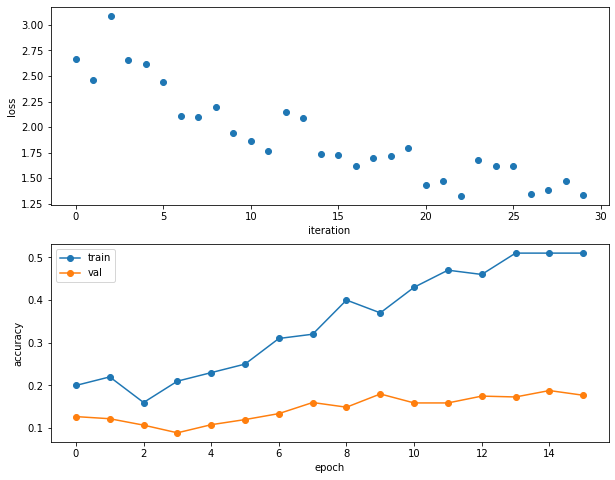

In [25]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Tuning Hyperparameter

In [33]:
best_model = None
model_param = {}

results = {}
best_val = -1
best_model = None

learning_rates = [9e-4, 1e-3, 3e-3]
reg_strength = [0.1, 0.001, 0.0001, 0.000001] 
batch_size = [50,100,300,500]
hidden_dim = [50, 100, 200, 500]

for lr in learning_rates:
  for rs in reg_strength:
    for bs in batch_size:
      for hd in hidden_dim:
        model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=hd, reg=rs)
        solver = Solver(model, small_data, num_epochs=3, batch_size=bs, update_rule='adam', 
        optim_config={'learning_rate': lr,}, verbose=True, print_every=2   0)
        solver.train()
        valid_accuracy = solver.check_accuracy(data['X_val'], data['y_val'])
        train_accuracy = solver.check_accuracy(data['X_train'], data['y_train'])
        
        if valid_accuracy > best_val:
          best_val = valid_accuracy
          best_model = solver
          model_param = {lr,rs,bs,hd}
"""
for lr, rs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, rs)]
    print('lr %e rs %e train accuracy: %f val accuracy: %f' % (
                lr, rs, train_accuracy, val_accuracy))
"""
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print(model_param)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 6) loss: 2.323173
(Epoch 0 / 3) train acc: 0.140000; val_acc: 0.108000
(Epoch 1 / 3) train acc: 0.120000; val_acc: 0.105000
(Epoch 2 / 3) train acc: 0.150000; val_acc: 0.124000
(Epoch 3 / 3) train acc: 0.210000; val_acc: 0.146000
(Iteration 1 / 6) loss: 2.343790
(Epoch 0 / 3) train acc: 0.130000; val_acc: 0.081000
(Epoch 1 / 3) train acc: 0.130000; val_acc: 0.081000
(Epoch 2 / 3) train acc: 0.150000; val_acc: 0.130000
(Epoch 3 / 3) train acc: 0.230000; val_acc: 0.142000
(Iteration 1 / 6) loss: 2.384688
(Epoch 0 / 3) train acc: 0.200000; val_acc: 0.123000
(Epoch 1 / 3) train acc: 0.210000; val_acc: 0.144000
(Epoch 2 / 3) train acc: 0.160000; val_acc: 0.108000
(Epoch 3 / 3) train acc: 0.370000; val_acc: 0.167000
(Iteration 1 / 6) loss: 2.508200
(Epoch 0 / 3) train acc: 0.130000; val_acc: 0.108000
(Epoch 1 / 3) train acc: 0.160000; val_acc: 0.120000
(Epoch 2 / 3) train acc: 0.110000; val_acc: 0.113000
(Epoch 3 / 3) train acc: 0.160000; val_acc: 0.104000
(Iteration 1 / 3) lo

## Train the Network

In [16]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(
    model,
    data,
    num_epochs=1,
    batch_size=50,
    update_rule='adam',
    optim_config={'learning_rate': 1e-3,},
    verbose=True,
    print_every=20
)
solver.train()

(Iteration 1 / 980) loss: 2.304740
(Epoch 0 / 1) train acc: 0.103000; val_acc: 0.107000
(Iteration 21 / 980) loss: 2.098229
(Iteration 41 / 980) loss: 1.949788
(Iteration 61 / 980) loss: 1.888398
(Iteration 81 / 980) loss: 1.877093
(Iteration 101 / 980) loss: 1.851877
(Iteration 121 / 980) loss: 1.859353
(Iteration 141 / 980) loss: 1.800181
(Iteration 161 / 980) loss: 2.143292
(Iteration 181 / 980) loss: 1.830573
(Iteration 201 / 980) loss: 2.037280
(Iteration 221 / 980) loss: 2.020304
(Iteration 241 / 980) loss: 1.823728
(Iteration 261 / 980) loss: 1.692679
(Iteration 281 / 980) loss: 1.882594
(Iteration 301 / 980) loss: 1.798261
(Iteration 321 / 980) loss: 1.851960
(Iteration 341 / 980) loss: 1.716323
(Iteration 361 / 980) loss: 1.897655
(Iteration 381 / 980) loss: 1.319744
(Iteration 401 / 980) loss: 1.738790
(Iteration 421 / 980) loss: 1.488866
(Iteration 441 / 980) loss: 1.718409
(Iteration 461 / 980) loss: 1.744440
(Iteration 481 / 980) loss: 1.605460
(Iteration 501 / 980) loss: 

KeyboardInterrupt: 

In [ ]:
# Print final training accuracy.
print(
    "Full data training accuracy:",
    solver.check_accuracy(data['X_train'], data['y_train'])
)